# References

Pandas:

https://pandas.pydata.org/docs/reference/api/pandas.DatetimeIndex.html

https://pandas.pydata.org/docs/user_guide/timeseries.html

# import modules

In [1]:
# imports
import pandas as pd
import numpy as np

# full-width display
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# pandas format
pd.set_option('display.float_format', '{:_.0f}'.format)
# NOTE: underscore separaters ('_') are better than commas (',') because 
# numbers with underscores work in Python without any extra effort.
pd.set_option('display.max_columns', None)

# plotting modules
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import matplotlib as mpl
%matplotlib inline
mpl.rcParams["axes.formatter.min_exponent"] = 20  # no scientific notation in graphs
plt.rcParams['axes.titley'] = 1.0    # y is in axes-relative coordinates.
plt.rcParams['axes.titlepad'] = 10   # pad is in points... default is 6
import seaborn as sns
sns.set_theme()

stop wrapping text in tables / dataframes

In [2]:
%%html
<style>.dataframe td {white-space: nowrap;}</style>

# import data

In [3]:
# NOTE this file IS NOT ON GITHUB, it is too big, so it is in gitignore
# run the RV Database notebook to create this file from the cleaned tables

# entire database in one dataframe (df for simplicity)
df = pd.read_csv(
    'RV_DATABASE.csv', 
    dtype={'MATURITY':object, 
           'STRAT':object, 
           'TOTNO':'Int64', 
           'SPEC':'Int64',
           'SPECIMEN_ID':'Int64'},
    parse_dates=['DATETIME']  # need to parse the DATETIME field as pd.datetime format
)

# sort by datetime and reindex
df = df.sort_values('DATETIME').reset_index(drop=True)

In [4]:
# individual tables used to define the database
SPECIES = pd.read_csv('SPECIES.csv', index_col = 'index')
SPECIES.columns = ['SPEC', 'COMMON_NAME', 'SCIENTIFIC_NAME']
MISSIONS = pd.read_csv('MISSIONS.csv')
GSCAT = pd.read_csv('GSCAT.csv')
GSINF = pd.read_csv('GSINF.csv', index_col='date and time', parse_dates=['date and time'])  # parse index as pd.datetime format
GSINF.index.name = 'DATETIME'
GSDET = pd.read_csv('GSDET.csv')

# helper functions

In [5]:
def get_species(species_code):
    return SPECIES[SPECIES.SPEC == species_code].COMMON_NAME.tolist()[0]

# test
get_species(10)

'COD(ATLANTIC)'

# EDA

### Haul Weights By Month, By Species

In [6]:
haul_weights = df[['DATETIME', 'MISSION', 'SETNO', 'TOTWGT', 'TOTNO', 'SPEC', 'COMMON_NAME']].drop_duplicates()

In [7]:
# monthly weights, totals and by species

# weights by species
monthly_weight_by_species = haul_weights.drop(['SETNO', 'TOTNO'], axis=1).groupby([haul_weights['DATETIME'].dt.year, haul_weights['DATETIME'].dt.month, 'SPEC']).sum()
monthly_weight_by_species = monthly_weight_by_species.reset_index(level=2)
monthly_weight_by_species.index.names = ['YEAR', 'MONTH']

# total weights
monthly_weight_totals = haul_weights.drop(['SETNO', 'TOTNO', 'SPEC'], axis=1).groupby([haul_weights['DATETIME'].dt.year, haul_weights['DATETIME'].dt.month]).sum()
monthly_weight_totals.index.names = ['YEAR', 'MONTH']

# join the two dataframes
monthly_weight_by_species = monthly_weight_by_species.merge(monthly_weight_totals, how='outer', on=['YEAR', 'MONTH']).rename(columns={'TOTWGT_x': 'SPEC_TOTAL', 'TOTWGT_y': 'MONTH_TOTAL'})

# calculate the proportion of species to the total
monthly_weight_by_species['PROP_TOTAL'] = monthly_weight_by_species['SPEC_TOTAL'] / monthly_weight_by_species['MONTH_TOTAL']

In [8]:
# how to format the output

monthly_weight_by_species.head(10).style.format({
    'SPEC': '{:_.0f}'.format,
    'SPEC_TOTAL': '{:_.0f}'.format,
    'MONTH_TOTAL': '{:_.0f}'.format,
    'PROP_TOTAL': '{:.2%}'.format
})

In [9]:
# proportion of haul by species by month
# NOTE: x-axis is not exactly proportional to time

def monthly_haul_proportion(species_code):
    spec_no = species_code
    species = get_species(spec_no)

    monthly_weight_by_species[monthly_weight_by_species.SPEC == spec_no].plot(
        kind='bar',
        width=1,
        y='PROP_TOTAL', 
        ylabel='Proportion of Total Haul',
        figsize=(36, 6), 
        legend=False, 
        title=f'Proportion of Haul by Month. Species: {species}'
    );

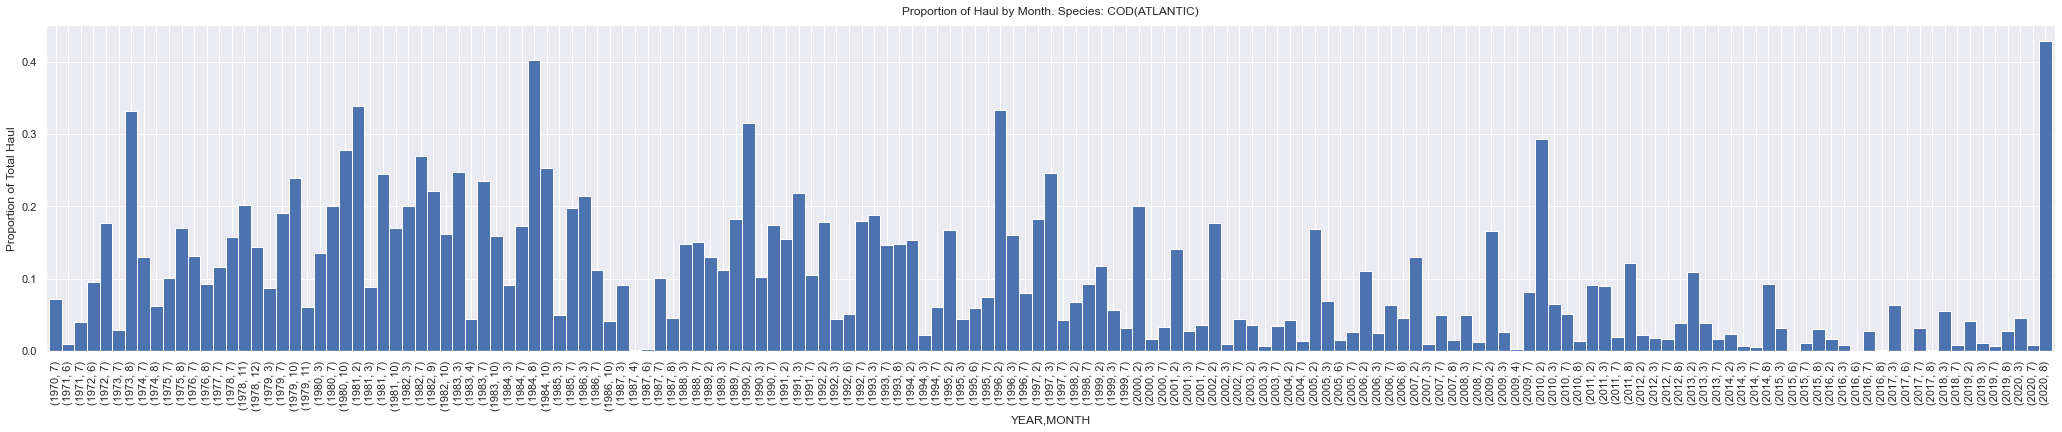

In [10]:
monthly_haul_proportion(10)

# Haul Weights By Year

In [11]:
# yearly weights, totals and by species

# weights by species
yearly_weight_by_species = haul_weights.drop(['SETNO', 'TOTNO'], axis=1).groupby([haul_weights['DATETIME'].dt.year, 'SPEC']).sum()
yearly_weight_by_species = yearly_weight_by_species.reset_index(level=1)
yearly_weight_by_species.index.names = ['YEAR']

# total weights
yearly_weight_totals = haul_weights.drop(['SETNO', 'TOTNO', 'SPEC'], axis=1).groupby([haul_weights['DATETIME'].dt.year]).sum()
yearly_weight_totals.index.names = ['YEAR']

# join the two dataframes
yearly_weight_by_species = yearly_weight_by_species.merge(yearly_weight_totals, how='outer', on=['YEAR']).rename(columns={'TOTWGT_x': 'SPEC_TOTAL', 'TOTWGT_y': 'YEAR_TOTAL'})

# calculate the proportion of species to the total
yearly_weight_by_species['PROP_TOTAL'] = yearly_weight_by_species['SPEC_TOTAL'] / yearly_weight_by_species['YEAR_TOTAL']

In [12]:
# proportion of haul by species by year

def yearly_haul_proportion(species_code):
    spec_no = species_code
    species = get_species(spec_no)

    yearly_weight_by_species[yearly_weight_by_species.SPEC == spec_no].plot(
        kind='bar',
        width=1,
        y='PROP_TOTAL', 
        ylabel='Proportion of Total Haul',
        figsize=(24, 8), 
        legend=False, 
        title=f'Proportion of Haul by Year. Species: {species}'
    );

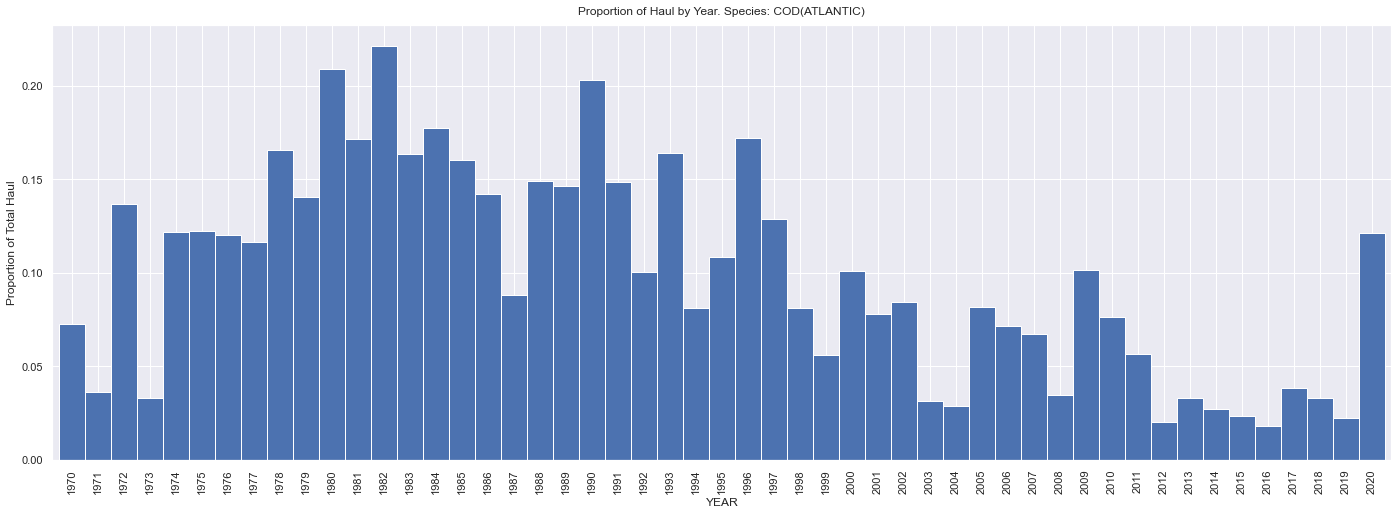

In [13]:
yearly_haul_proportion(10)

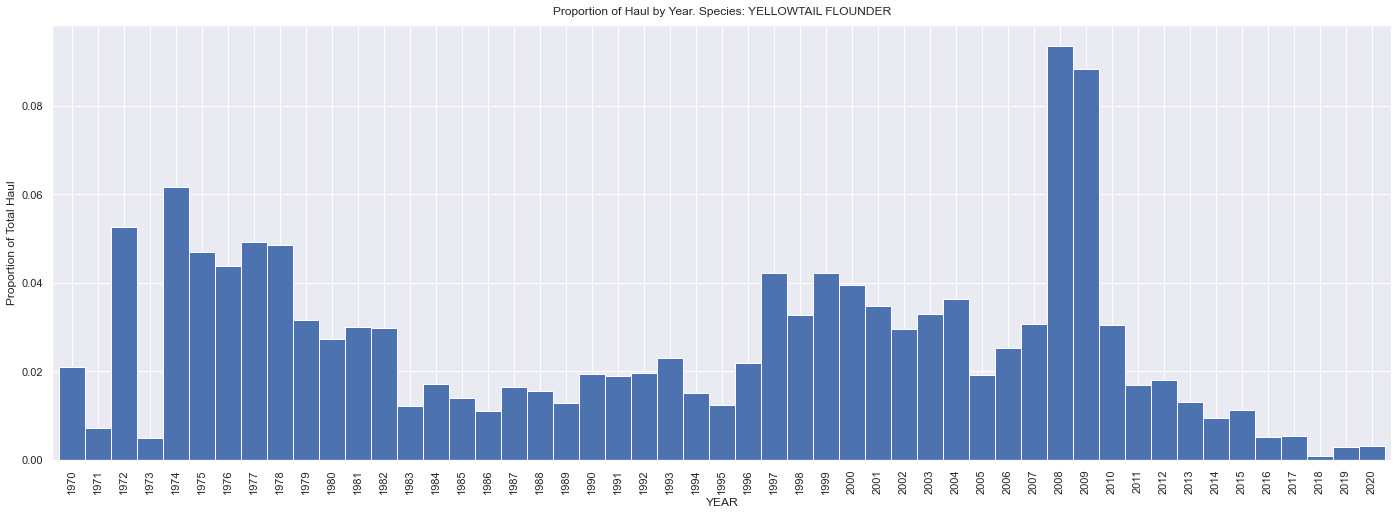

In [14]:
yearly_haul_proportion(42)

# improved chart with filtering

In [96]:
def filtered_haul(species_code, data_filter = None):
    
    # columns to include
    columns = ['DATETIME', 'MISSION', 'SETNO', 'TOTWGT', 'TOTNO', 'SPEC', 'COMMON_NAME']
    
    # species input
    spec_no = species_code
    species = get_species(spec_no)

    # filter the data
    if type(data_filter) == type(None):
        haul_weights_filtered = df[columns].drop_duplicates()
        title=f'Proportion of Haul by Year. Species: {species}.'
    else:
        haul_weights_filtered = df[data_filter][columns].drop_duplicates()
        title=f'Proportion of Haul by Year. Species: {species}. Filtered.'

    # weights by species
    yearly_weight_by_species = (
        haul_weights_filtered
        .drop(['SETNO', 'TOTNO'], axis=1)
        .groupby([haul_weights_filtered['DATETIME'].dt.year, 'SPEC']).sum()
    )
    yearly_weight_by_species = yearly_weight_by_species.reset_index(level=1)
    yearly_weight_by_species.index.names = ['YEAR']

    # total weights
    yearly_weight_totals = (
        haul_weights_filtered
        .drop(['SETNO', 'TOTNO', 'SPEC'], axis=1)
        .groupby([haul_weights_filtered['DATETIME'].dt.year]).sum()
    )
    yearly_weight_totals.index.names = ['YEAR']

    # join the two dataframes
    yearly_weight_by_species = (
        yearly_weight_by_species
        .merge(yearly_weight_totals, how='outer', on=['YEAR'])
        .rename(columns={'TOTWGT_x': 'SPEC_TOTAL', 'TOTWGT_y': 'YEAR_TOTAL'})
    )

    # calculate the proportion of species to the total
    yearly_weight_by_species['PROP_TOTAL'] = (
        yearly_weight_by_species['SPEC_TOTAL'] / yearly_weight_by_species['YEAR_TOTAL']
    )

    # graph the proportion of haul by species by year
    yearly_weight_by_species[yearly_weight_by_species.SPEC == spec_no].plot(
        kind='bar',
        width=1,
        y='PROP_TOTAL', 
        ylabel='Proportion of Total Haul',
        figsize=(24, 8), 
        legend=False, 
        title=title
    );

In [25]:
df.columns

Index(['DATETIME', 'SEASON', 'MISSION', 'SETNO', 'TOTWGT', 'TOTNO', 'SPEC',
       'COMMON_NAME', 'SCIENTIFIC_NAME', 'FLEN', 'FWT', 'MATURITY', 'SEX',
       'AGE', 'SPECIMEN_ID', 'STRAT', 'SLAT', 'SLONG', 'ELAT', 'ELONG', 'DUR',
       'DIST', 'SPEED', 'DEPTH', 'SURF_TEMP', 'BOTT_TEMP', 'BOTT_SAL',
       'GEARDESC', 'VESEL', 'CRUNO', 'YEAR'],
      dtype='object')

In [32]:
# use DEPTH as an example test case
df.DEPTH.describe()

count   2_345_761
mean          139
std           108
min            20
25%            78
50%           108
75%           170
max         1_806
Name: DEPTH, dtype: float64

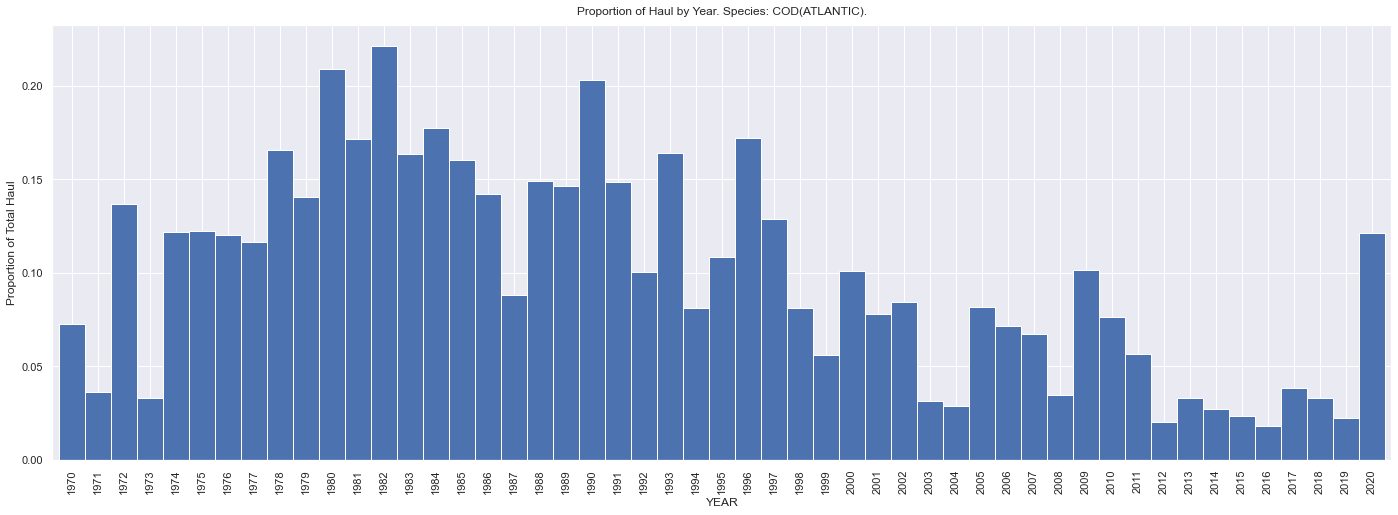

In [97]:
filtered_haul(10)

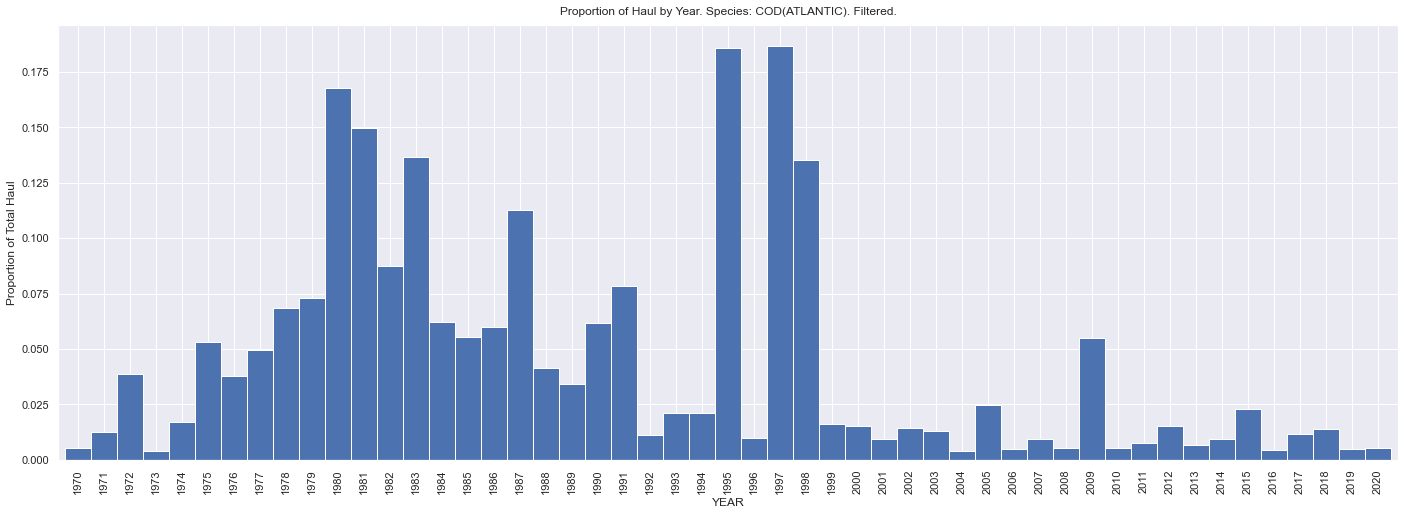

In [98]:
data_filter = (df.DEPTH > 200)
filtered_haul(10, data_filter)

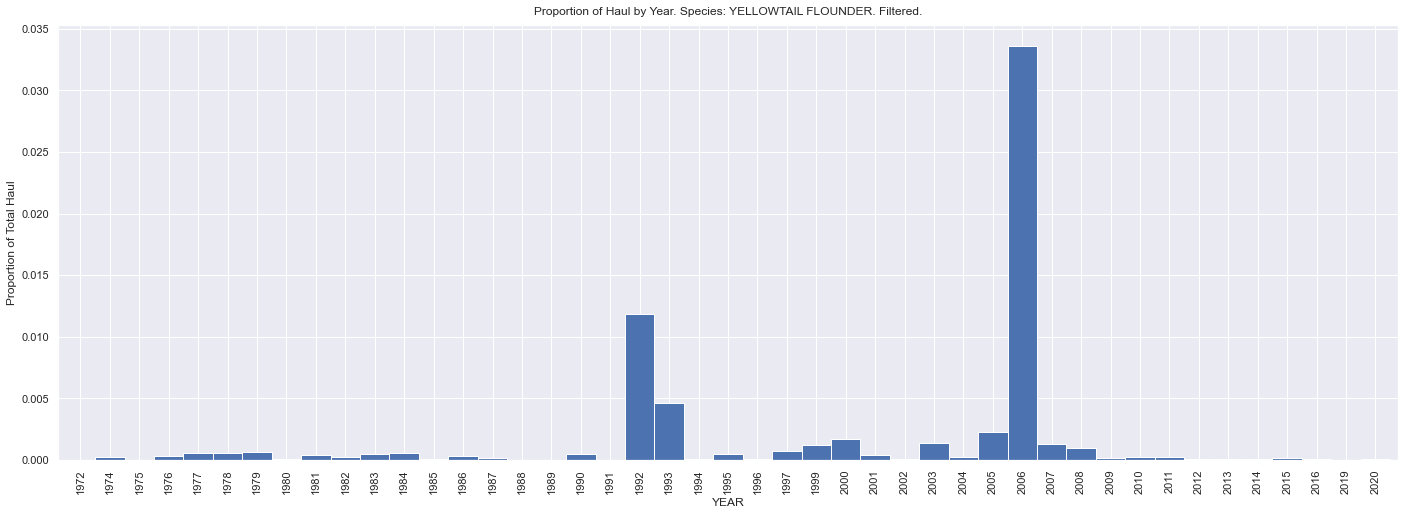

In [99]:
data_filter = (df.DEPTH > 200)
filtered_haul(42, data_filter)